In [78]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from statsmodels.datasets import co2, get_rdataset

from plotnine import *

from statsmodels.tsa.seasonal import seasonal_decompose, STL

from statsmodels.tsa.filters.hp_filter import hpfilter

from statsmodels.tsa.stattools import adfuller, kpss

import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

from scipy.stats import shapiro, kstest, normaltest
from statsmodels.stats.diagnostic import kstest_normal, normal_ad

from statsmodels.tsa.api import AutoReg

from statsmodels.stats.api import (het_breuschpagan, het_goldfeldquandt, het_white)

from scipy.stats import boxcox

from statsmodels.stats.diagnostic import acorr_ljungbox



In [62]:
# Dataset: AirPassengers
air_passengers = get_rdataset("AirPassengers")
airp_df = air_passengers.data
airp_df.index = pd.date_range('1949', '1961', freq='M')
airp_df.drop(columns=['time'], inplace=True)

In [63]:
# Dataset: co2
co2_df = co2.load_pandas().data
co2_df = co2_df.ffill()

# Aplicando power transformations
-   Dependendo do modelo e da análise que você está buscando, pode ser necessário testar suposições adicionais em relação ao conjunto de dados observado ou aos resíduos do modelo.
    - Mais especificamente, é a variância dos resíduos. Quando a variância não é constante, mudando ao longo do tempo, chamamos de heteroscedasticidade
    - Outra suposição que você precisará testar é a normalidade; a observação específica vem de um distribuição normal? 
    - As vezes, você também pode querer verificar a normalidade dos resíduos, o que pode fazer parte do estágio de diagnóstico do modelo.

OBS: Se você não fizer isso (checar), poderá acabar com um modelo falho ou um resultado excessivamente otimista ou excessivamente pessimista. 
    - A transformação ''''Box-Cox'''': pode ser usada para transformar os dados e satisfazer a normalidade e a homoscedasticidade

# Transformação boxcox
    - A transformação Box-Cox depende de apenas um parâmetro, lambda ( λ)
        - Se o parâmetro lmbda estiver definido como None, a função encontrará o valor lambda (λ) ideal para você.

# Testing normality
    - Convenientemente, os testes a seguir têm a mesma hipótese nula. 
        - A hipótese nula afirma que os dados são normalmente distribuídos

In [64]:
# Função que retorna se é ou não normal
def is_normal(test, p_level=0.05):
    stat, pval = test
    
    return 'Normal' if pval > 0.05 else 'Not Normal'

In [65]:
# Testes simutâneos
normal_args = (np.mean(co2_df),np.std(co2_df))
print(is_normal(shapiro(co2_df)))
print(is_normal(normaltest(co2_df)))
print(is_normal(normal_ad(co2_df)))
print(is_normal(kstest_normal(co2_df)))
print(is_normal(kstest(co2_df, cdf='norm', args=(np.mean(co2_df), np.std(co2_df)))))


Not Normal
Not Normal
Not Normal
Not Normal
Not Normal


c:\Users\Pc\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'


In [66]:
# Testando normalidade dos resíduos
model = AutoReg(co2_df.dropna(), lags=1).fit()

print(is_normal(shapiro(model.resid)))

Not Normal


# TESTEANDO HOMOCEDASTICIDADE DO RESÍDUOS
    - Você testará a estabilidade da variância em relação aos resíduos do modelo. Este será o mesmo modelo AR(1) usado no teste de normalidade anterior:
        - H0: A hipótese nula afirma que os dados são homocedásticos

In [67]:
def het_test(model, test=het_breuschpagan):
    lm, lm_pvalue, fvalue, f_pvalue = (
        het_breuschpagan(model.resid, 
                         sm.add_constant(
                             model.fittedvalues)
                        ))
    
    return "Heteroskedastic" if f_pvalue < 0.05 else "Homoskedastic"

In [68]:
# Breusch-Pagan Lagrange multiplier test
het_test(model, test=het_breuschpagan)

'Homoskedastic'

In [69]:
# White's Lagrange multiplier test
het_test(model, test=het_white)

# Ambos os testes indicam que os resíduos do modelo autorregressivo possuem variância constante (homoscedástico). Ambos os testes estimam a regressão auxiliar contra os resíduos quadrados e todas as variáveis explicativas

'Homoskedastic'

# TRANSFORMAÇÃO BOX-COX: existe um parâmetro lambda usado para determinar qual transformação aplicar (logarithm or power transform)
    - transforma um conjunto de dados não normalmente distribuído em um normalmente distribuído.
    - Ao mesmo tempo, estabiliza a variância, tornando os dados homocedásticos.
    - Uma coisa a apontar é que a função boxcox requer que os dados sejam positivos.

In [70]:
airp_df.head(5)

,value
1949-01-31,112
1949-02-28,118
1949-03-31,132
1949-04-30,129
1949-05-31,121


In [71]:
# DEFAULT: LAMBDA: NONE - a função encontra um valor de lambda ideal
xt, lmbda = boxcox(airp_df['value']) 
xts = pd.Series(xt, index=airp_df.index, name='value')

print(lmbda)
xts.head(5)

0.14802265137037945


1949-01-31    6.827490
1949-02-28    6.932822
1949-03-31    7.161892
1949-04-30    7.114611
1949-05-31    6.983787
Freq: M, Name: value, dtype: float64

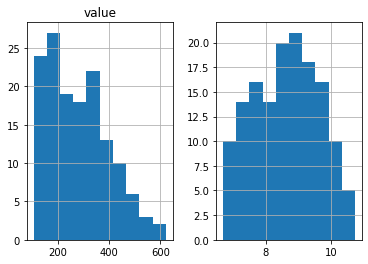

In [72]:
# Um histograma pode mostrar visualmente o impacto da transformação:
fig, ax = plt.subplots(1, 2)
airp_df.hist(ax=ax[0])
xts.hist(ax=ax[1])
plt.show()

c:\Users\Pc\anaconda3\lib\site-packages\plotnine\stats\stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 8'. Pick better value with 'binwidth'.


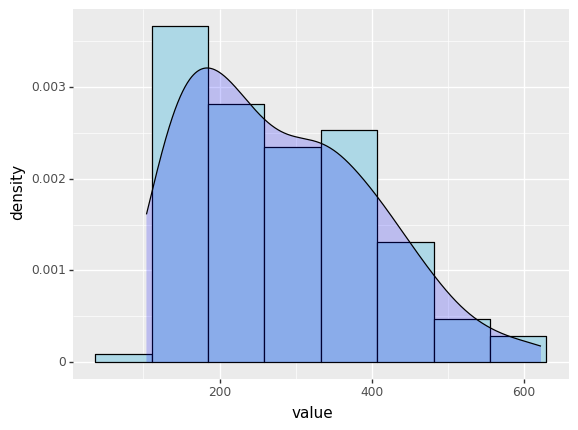

<ggplot: (158125646674)>

In [73]:
ggplot(airp_df, aes(x='value',y='..density..'))+geom_histogram(fill='lightblue',colour='black')+geom_density(fill='blue', alpha=0.2)

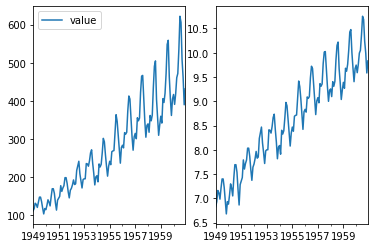

In [74]:
fig, ax = plt.subplots(1, 2)
airp_df.plot(ax=ax[0])
xts.plot(ax=ax[1])
plt.show() 

# Observe como o efeito sazonal no conjunto de dados transformado parece mais estável do que antes

<AxesSubplot: >

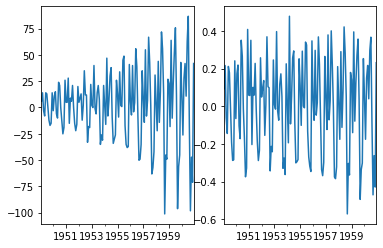

In [75]:
# Ajustando modelo para comparar os resíduos
model_airp = AutoReg(airp_df, lags=1, trend='n').fit()

model_bx = AutoReg(xts, lags=1, trend='n').fit()

fig, ax = plt.subplots(1, 2)
model_airp.resid.plot(ax=ax[0])
model_bx.resid.plot(ax=ax[1])

# Box-Cox nos permite tornar os dados normais e homoscedásticos e faz parte de uma família de transformações de potência que inclui transformação de log e 
# transformação de raiz quadrada.

In [76]:
# Resumo dos modelos
print(model_bx.diagnostic_summary())

       Test of No Serial Correlation       
       Lag  Ljung-Box LB P-value         DF
-------------------------------------------
         1      8.800      0.003          1
         2     12.729      0.002          2
         3     28.040      0.000          3
         4     29.202      0.000          4
         5     29.205      0.000          5
         6     31.021      0.000          6
         7     47.992      0.000          7
         8     50.468      0.000          8
         9     52.247      0.000          9


             Test of Normality              
Jarque-Bera    P-value   Skewness   Kurtosis
--------------------------------------------
      5.987      0.050     -0.128      2.031


    Test of Conditional Homoskedasticity   
       Lag    ARCH-LM    P-value         DF
-------------------------------------------
         1      0.116      0.733          1
         2      1.243      0.537          2
         3      4.112      0.250          3
         4      4.058   

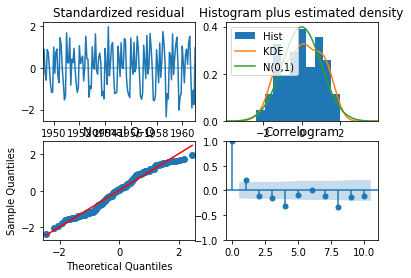

In [79]:
# EXIMANDO OS RESÍDUOS DO MODELO
model_bx.plot_diagnostics(); plt.show()

# Gráfico Q-Q e do histograma: VERIFICAR NORMALIDADE
# Gráfico de ACF: permitirá examinar a autocorrelação

# TESTE DE AUTOCORRELAÇÃO: medimos a relação linear entre os valores da série temporal separados por um atraso (lag). Em outras palavras, estamos comparando uma variável com sua versão defasada de si mesma.
    - teste Ljung-Box: A hipótese nula para o teste Ljung-Box afirma que os lags anteriores não estão correlacionados com o período atual. Ou seja,
    H0: ausência de autocorrelação
    
    - Ao testar a autocorrelação nos resíduos, a expectativa é que não haja autocorrelação entre os resíduos. Isso garante que o modelo capturou todas as informações necessárias.

OBS: A presença de autocorrelação nos resíduos pode indicar que o modelo perdeu uma oportunidade de capturar informações críticas e precisará ser avaliado

In [81]:
# Os dados de CO2 são não estacionários:: então iremos aplicar uma transformação nos dados
co2_diff= np.log(co2_df).diff().dropna()
co2_diff

,co2
1958-04-05,0.003789
1958-04-12,0.000945
1958-04-19,-0.000315
1958-04-26,-0.003471
1958-05-03,0.001579
...,...
2001-12-01,0.000000
2001-12-08,0.001349
2001-12-15,0.001078
2001-12-22,0.000269


In [82]:
# lags = 10 é o lag máximo testado::: ele varia ate 10
acorr_ljungbox(co2_diff, lags=10, return_df=True)

# Isso mostra que a estatística de teste para todos os atrasos até o atraso 10 é significativa (p-valor < 0,05), 
# portanto, você pode rejeitar a hipótese nula. Rejeitar a hipótese nula significa rejeitar a alegação de que não há autocorrelação.

,lb_stat,lb_pvalue
1,16.193898,5.717801e-05
2,78.485798,9.057856e-18
3,287.050787,6.311581e-62
4,383.291716,1.132455e-81
5,493.588582,1.932434e-104
6,536.683057,1.047943e-112
7,598.257880,5.776363e-125
8,620.615981,8.637442e-129
9,626.775866,3.739862e-129
10,631.630413,2.925751e-129


In [83]:
acorr_ljungbox(model_bx.resid, return_df=True, lags=10)

,lb_stat,lb_pvalue
1,6.891379,8.661245e-03
2,8.799865,1.227817e-02
3,12.728606,5.261829e-03
4,28.039695,1.224399e-05
5,29.201881,2.116595e-05
6,29.204901,5.563811e-05
7,31.021143,6.161812e-05
8,47.991784,9.915323e-08
9,50.468158,8.794752e-08
10,52.247452,1.026842e-07
